In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyeviews as evp # for eviews (ev)
import matplotlib.dates as mdates
from scipy.optimize import minimize
from math import e

#Importing the functions that we created
import functions_needed as fn
import model_BK as bk

import warnings
warnings.filterwarnings("ignore")


**Import Data**
<br>I am importing the data using eviews. If you are replicating this program, you can replace this section to your method of receiving the data.
<br> In my example I am importing 2 year government bond yield for Canada, US, and UK.

In [11]:
eviewsapp = evp.GetEViewsApp(instance='new',showwindow=True)
#evp.Run('WFCREATE d5 '+str(startyr)+' '+str(dt.date.today().year), app=eviewsapp)
evp.Run('run "R:/Tenzin/3.GFIC/Eviews/Daily Pro/daily pro 20250311 scratch pad (canada zero coupon).prg"', app=eviewsapp)
df_ev = evp.GetWFAsPython(app=eviewsapp)
eviewsapp.Hide()
eviewsapp = None
evp.Cleanup()

df = df_ev.dropna()
df.tail(5)

,CA2YGOVI,GB2YGOVI,US2YGOVI
2025-03-17,2.52,4.18,4.06
2025-03-18,2.52,4.19,4.04
2025-03-19,2.49,4.20,3.99
2025-03-20,2.50,4.23,3.95
2025-03-21,2.49,4.26,3.94


**First we create the covariance matrix to get the sigma**

In [12]:
df_vcv = pd.DataFrame.cov(df) 
df_vcv

,CA2YGOVI,GB2YGOVI,US2YGOVI
CA2YGOVI,0.737188,0.777251,0.744932
GB2YGOVI,0.777251,1.385130,1.047484
US2YGOVI,0.744932,1.047484,0.940707


**Calling the BK model**
<br> The code below loops through the bond yields of different countries from the database and computes the BK model

In [22]:


# #Empty dataframe for the parameters
df_para = pd.DataFrame()
df_bk_san = pd.DataFrame()

#Initial shape of the dataframe to start adding to the dataframe
row, col_length = df_para.shape
row_not_using_this, col_length_bk_san = df_para.shape

#cunter for the loop
count = 0

for columnName in df.columns.values: 
   # set up parameters
   r0 = abs(df[columnName].iloc[0]) #Base case starts from the starting time of bond yield. If you want to add forcast to the model switch base case to the end of time ie. iloc[len(df)-1] 
   n = len(df)-1 #number of scnarios which set to equal to the length of the bond yield data frame. 
   T = 2 #maturity
   #t = np.linspace(0, T, n+1)
   r_market = df[columnName] #this is the market yield aka actual bond yield. The variable is assigned to be used for model calibration

   #Calling the function for mean reversion speed and mean recersion level.
   a,k = fn.paramater_(df[columnName])  

   #Getting the Diagnol Sigma Value from the vcv matrix we created before
   sigma = df_vcv[columnName].values[count] #Skipping base case
   
   #Initial values for the parameters for the model
   theta0 = np.ones(n) * (e**k) 
   alpha0 = np.ones(n) * (e**a)
   sigma0 = np.ones(n) * sigma
   x0 = np.concatenate([theta0, alpha0, sigma0])

   #calibration -- At the moment I commented this out becuase the calibration performs worst than the initial parameters
   #res = minimize(bk.calibration_obj, x0, args=(r0, r_market.values, T, n))
   #Getting the claibrated parameter values
   #theta, alpha, sigma = res.x[:n], res.x[n:2*n], res.x[2*n:]

   bk_result = bk.black_karasinski(r0, theta0, alpha0, sigma0, T, n)

   #inserting values to the Parameter dataframe
   df_para.insert(col_length, columnName, [a,k], True) 
   row, col_length = df_para.shape

   #Inserting the value for the BK model
   df_bk_san.insert(col_length_bk_san, columnName, bk_result, True) 
   row, col_length_bk_san = df_bk_san.shape

   count += 1

#[a,k]
df_para.index = ['Mean Reversion Speed','Mean Reversion Level']
df_para = df_para.T



**Plot**

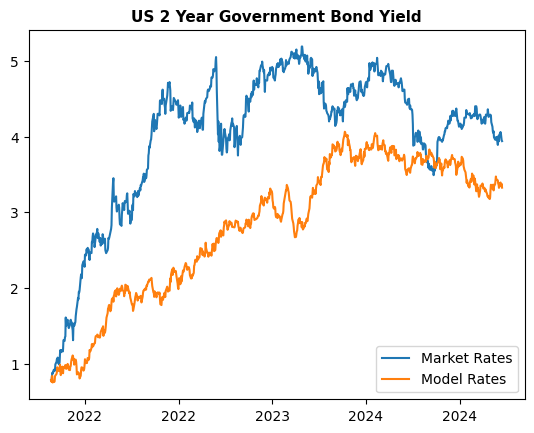

In [25]:
columnName = "US2YGOVI"
plt.title('US 2 Year Government Bond Yield', fontsize=11, color='Black', fontweight='bold')
plt.plot(df.index, df[columnName], label='Market Rates')
plt.plot(df.index, df_bk_san[columnName], label='Model Rates')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))
plt.legend()
plt.show()


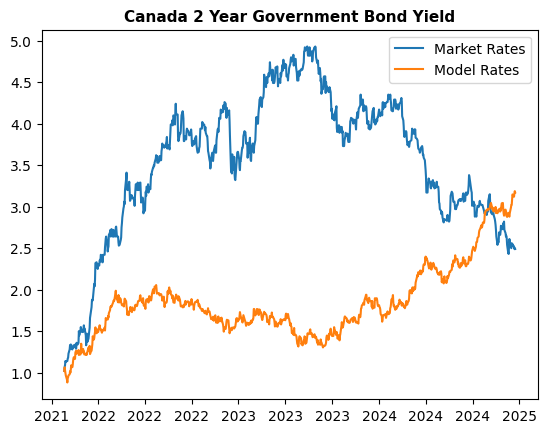

In [24]:
columnName = "CA2YGOVI"
plt.title('Canada 2 Year Government Bond Yield', fontsize=11, color='Black', fontweight='bold')
plt.plot(df.index, df[columnName], label='Market Rates')
plt.plot(df.index, df_bk_san[columnName], label='Model Rates')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.legend()
plt.show()
